# Okama

Цены закрытия всех тикеров по дням

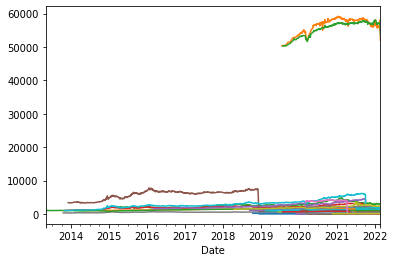

In [82]:
import okama as ok
import pandas as pd

#iFXIT - отсутсвует в базе данных
with open('Data/ETFs') as file:
    tickers = file.read().split()

All_ticker_assets = pd.DataFrame()

for tick in tickers:
    ticker_asset = ok.Asset(f'{tick}.MOEX')
    ticker_asset.close_daily.plot()


# Шарп и Сортино с помощью Okama

In [84]:

import okama as ok
import pandas as pd

result = pd.DataFrame()

with open('Data/ETFs') as file:
    tickers = [f'{i}.MOEX' for i in file.read().split()]

ticker_asset = ok.AssetList(tickers, ccy='RUB', inflation=True)

s2=ticker_asset.get_sharpe_ratio(rf_return=0.0001)
s3=ticker_asset.index_beta
s4=ticker_asset.get_sortino_ratio(t_return=0.03)



result['Sharp'] = s2
#result['Beta'] = s3
result['Sortino'] = s4

result

,Sharp,Sortino
AKNX.MOEX,-1.582579,-1.989950
AMCC.MOEX,-4.526339,-3.377046
AMDG.MOEX,1.137151,1.868944
AMEM.MOEX,8.900693,21.996640
AMGF.MOEX,-0.799531,-1.032028
...,...,...
VTBI.MOEX,0.645534,-0.347114
VTBM.MOEX,12.913812,10.806188
VTBU.MOEX,-1.503361,-1.376037
VTBX.MOEX,-5.629863,-1.759916


# apimoex

In [1]:
import requests
import pqr
import apimoex
import numpy as np
import pandas as pd
from empyrical import *

#Режим торгов
board = 'TQTF'

#Чтение списка тикеров из файла
with open("Data/ETFs", "r") as TICKs:
    TICKs = [line.rstrip() for line in TICKs]

process = 0

Data = []


#Загрузка истории тикеров с биржы
with requests.Session() as session:
    for TICK in TICKs:
        process = process + 1
        data = apimoex.get_board_history(session, TICK, board=board)
        if data == []:
             continue
        df = pd.DataFrame(data)
        df = df[['TRADEDATE','CLOSE']]
        df.rename(columns={'CLOSE': TICK}, inplace=True)
        
        Data.append(df)


        
#Объединяемм по дате все датасеты тикеров
result = Data[0]
for i in range(1, len(Data)):
    result = pd.merge(result, Data[i], on='TRADEDATE')

#Вручную из файла добавляем RTSTR (из-за отсутствия возможности загрузки через api)
rtstr = pd.read_csv('Data/RTSTR.csv', delimiter=';')
rtstr = rtstr[['<DATE>', '<CLOSE>']]

#Преобразуем дату к стандарту apimoex
for i in range(len(rtstr['<DATE>'])):
    rtstr['<DATE>'].iloc[i] = str(rtstr['<DATE>'].iloc[i])[:4] + '-' + str(rtstr['<DATE>'].iloc[i])[4:6] + '-' + str(rtstr['<DATE>'].iloc[i])[6:]

#Меняем названия колонок
rtstr.rename(columns={'<DATE>': 'TRADEDATE', '<CLOSE>': 'RTSTR'}, inplace=True)

#Объединяемм по дате RTSTR с датасетом всех тикеров
result = pd.merge(result, rtstr, on='TRADEDATE')


#Высчитывает returns для каждого тикера
for TICK in TICKs:
    result[f'{TICK}_return'] = None
    for i in range(1, len(result[TICK])):
        x_prev = result[TICK].iloc[i-1]
        x_now = result[TICK].iloc[i]
        result[f'{TICK}_return'].iloc[i] = (x_prev / x_now) / x_prev
    
result['RTSTR_return'] = None
for i in range(1, len(result['RTSTR'])):
    x_prev = result['RTSTR'].iloc[i-1]
    x_now = result['RTSTR'].iloc[i]
    result['RTSTR_return'].iloc[i] = (x_prev / x_now) / x_prev

#Убираем строки с пустыми значениями
result = result.dropna()

<ipython-input-1-a3a8e8ce79dd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f'{TICK}_return'].iloc[i] = (x_prev / x_now) / x_prev
<ipython-input-1-a3a8e8ce79dd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f'{TICK}_return'].iloc[i] = (x_prev / x_now) / x_prev
<ipython-input-1-a3a8e8ce79dd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[f'{TICK}_return'].iloc[i] = (x_prev / x_now) / x_prev
<ipython-inpu

In [2]:
result

,TRADEDATE,AKNX,AMCC,AMDG,AMEM,AMGF,AMGM,AMGR,AMHC,AMHY,...,VTBE_return,VTBF_return,VTBG_return,VTBH_return,VTBI_return,VTBM_return,VTBU_return,VTBX_return,VTBY_return,RTSTR_return
9,2021-11-26,1787.5,106.6,108.5,90.8,114.0,95.3,70.8,110.7,99.8,...,0.010975,0.010662,0.890472,0.012225,0.009938,0.9176,0.009643,0.006651,0.010565,0.000332
10,2021-11-29,1781.5,106.0,106.9,90.0,113.6,92.8,68.1,108.9,99.5,...,0.011071,0.010571,0.905387,0.012247,0.010136,0.917515,0.00979,0.00651,0.010779,0.000322
21,2021-12-14,1709.5,97.4,107.8,89.6,110.5,88.1,64.3,108.6,98.8,...,0.011123,0.011025,0.921999,0.012302,0.01023,0.914913,0.009879,0.006937,0.01086,0.00034
22,2021-12-15,1723.0,97.4,108.4,88.6,110.6,87.0,63.8,110.1,99.4,...,0.011189,0.0109,0.917768,0.012297,0.010171,0.914662,0.009901,0.006868,0.010828,0.000342
30,2021-12-27,1781.5,101.3,109.2,90.2,113.7,91.6,66.3,112.9,100.3,...,0.011078,0.010691,0.906618,0.012217,0.010225,0.912326,0.009938,0.0067,0.010858,0.000326
31,2021-12-28,1794.0,101.0,110.9,90.4,115.1,92.3,66.5,113.7,100.4,...,0.011062,0.010622,0.904568,0.012194,0.010167,0.912159,0.009907,0.006673,0.010819,0.000325
32,2021-12-29,1782.5,100.3,111.2,90.0,115.1,92.5,63.7,114.3,101.0,...,0.011041,0.010611,0.902527,0.012102,0.010184,0.911328,0.009881,0.006676,0.010742,0.000329
40,2022-01-12,1742.5,97.6,111.0,95.0,110.9,93.4,59.4,110.4,100.9,...,0.010502,0.010309,0.884877,0.012079,0.010205,0.908513,0.009796,0.006542,0.010593,0.000324
41,2022-01-13,1767.0,96.0,113.2,96.6,112.5,95.6,57.3,112.5,102.8,...,0.01044,0.01054,0.870322,0.011933,0.010072,0.908183,0.009628,0.006777,0.010381,0.000343
42,2022-01-14,1733.5,94.0,111.3,95.5,110.2,94.8,56.8,110.7,102.3,...,0.010476,0.010715,0.870474,0.011906,0.010098,0.907853,0.009724,0.006925,0.010465,0.00035


# На основе заготовки данных высчитываем коэффициенты

In [7]:
RES = pd.DataFrame(index =['Alpha', 'Beta', 'Sharp', 'Treynor', 'Sortino'])
RES

""
Alpha
Beta
Sharp
Treynor
Sortino


In [8]:
for TICK in TICKs:
    RES[TICK] = None
RES

<ipython-input-8-fae3ef4df632>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  RES[TICK] = None
<ipython-input-8-fae3ef4df632>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  RES[TICK] = None
<ipython-input-8-fae3ef4df632>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  RES[TICK] = None
<ipython-i

,AKNX,AMCC,AMDG,AMEM,AMGF,AMGM,AMGR,AMHC,AMHY,AMIG,...,VTBB,VTBE,VTBF,VTBG,VTBH,VTBI,VTBM,VTBU,VTBX,VTBY
Alpha,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Beta,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Sharp,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Treynor,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Sortino,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [12]:
for TICK in TICKs:
    prob = pd.Series(index=result['TRADEDATE'], data=result[f'{TICK}_return'])
    #RES[TICK].loc['Sharp'] = pqr.metrics.sharpe_ratio(prob, risk_free_rate=0)
    RES[TICK].loc['Sortino'] = sortino_ratio(returns=prob)

/Users/georgijgusakov/opt/anaconda3/lib/python3.8/site-packages/empyrical/utils.py:50: RuntimeWarning: Mean of empty slice
  data = f(*args, **kwargs)
/Users/georgijgusakov/opt/anaconda3/lib/python3.8/site-packages/empyrical/utils.py:50: RuntimeWarning: Mean of empty slice
  data = f(*args, **kwargs)
/Users/georgijgusakov/opt/anaconda3/lib/python3.8/site-packages/empyrical/utils.py:50: RuntimeWarning: Mean of empty slice
  data = f(*args, **kwargs)
/Users/georgijgusakov/opt/anaconda3/lib/python3.8/site-packages/empyrical/utils.py:50: RuntimeWarning: Mean of empty slice
  data = f(*args, **kwargs)
/Users/georgijgusakov/opt/anaconda3/lib/python3.8/site-packages/empyrical/utils.py:50: RuntimeWarning: Mean of empty slice
  data = f(*args, **kwargs)
/Users/georgijgusakov/opt/anaconda3/lib/python3.8/site-packages/empyrical/utils.py:50: RuntimeWarning: Mean of empty slice
  data = f(*args, **kwargs)
/Users/georgijgusakov/opt/anaconda3/lib/python3.8/site-packages/empyrical/utils.py:50: Runtime

In [13]:
RES

,AKNX,AMCC,AMDG,AMEM,AMGF,AMGM,AMGR,AMHC,AMHY,AMIG,...,VTBB,VTBE,VTBF,VTBG,VTBH,VTBI,VTBM,VTBU,VTBX,VTBY
Alpha,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Beta,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Sharp,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Treynor,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Sortino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1]:
for TICK in TICKs:
    ret = np.array(result[f'{TICK}_return'], dtype='<U21')
    fact = np.array(result['RTSTR_return'], dtype='<U21')
    RES[TICK].loc['Sortino'] = sortino_ratio(returns=ret)
    

NameError: name 'TICKs' is not defined